# Semantic Segmentation of Water using U-Net
# Part 4 - Data Augmentation


In this part I will build a larger training dataset by applying data augmentation techniques to the original images.

In [1]:
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import concatenate, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, save_img
import numpy as np
import json, os
from random import shuffle
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import warnings
import re
import time

In [2]:
from unetlib.preprocessing import get_lakes_with_masks, make_dataframes_for_flow
import unetlib.visualisation as vs

In [3]:
# Imagery directories
nwpu_data_dir = 'nwpu_lake_images/data/'
nwpu_mask_dir = 'nwpu_lake_images/masks/'

In [4]:
# Split the test/train data
train_img_df, train_msk_df, test_img_df, test_msk_df, = make_dataframes_for_flow(nwpu_data_dir,
                                                                                 nwpu_mask_dir,
                                                                                 test_size=0.25,
                                                                                 random_state=42
                                                                                )

Data augmentations are any transformation that can be applied to the data (images in this case) to produce a new version of the data. These transformations can include flipping the image, zooming in/out, skewing, rotating etc.

The aim is to create new images that still look like the training data but have appropriate variation that one might expect in the real world. For example it makes sense to rotate and flip the lake images because they can exist in a huge range of shapes and sizes. On the other hand, consider OCR - flipping the images would flip the characters which then would lose meaning and not really represent the real world input data to the model.

These new images provide more data and more variation than the original dataset allowing the network to learn to generalise better. In this respect augmentation acts as a sort of regulariser.

To illustrate, I'll apply some random transformations to an image and show the output. The Pillow library contains useful functions for doing this.

In [7]:
# Select a random image
rand_img = train_img_df.sample(1)
rand_img_fn = os.path.join(nwpu_data_dir, rand_img.filename.squeeze())
print(rand_img_fn)

nwpu_lake_images/data/lake_168.jpg


Augmentations:
	Horizontal Flip: False
	Vertical Flip: True
	Rotation: 30


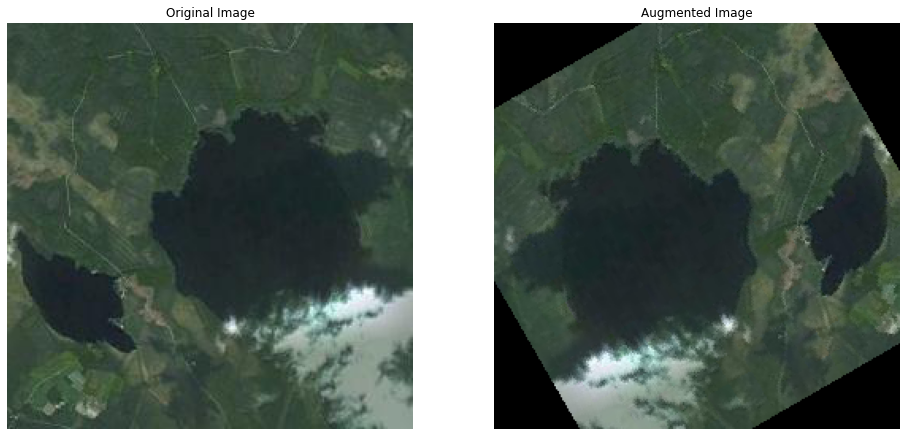

In [8]:
# Define a few augmentations
hflip = np.random.choice([True,False])
vflip = np.random.choice([True,False])
rot = np.random.choice(range(30,80,10))

print(f'Augmentations:\n\tHorizontal Flip: {hflip}'
      f'\n\tVertical Flip: {vflip}\n\tRotation: {rot}'
     )

# Open image
img = Image.open(rand_img_fn)

# Create axes and plot original
fig, axes = plt.subplots(1,2,figsize=(16,8))
axes[0].imshow(img)
axes[0].axis('off')
axes[0].set_title('Original Image')

# Apply augmentations
if hflip:
    img = img.transpose(Image.FLIP_TOP_BOTTOM)
if vflip:
    img = img.transpose(Image.FLIP_LEFT_RIGHT)
img = img.rotate(rot)

# Plot the augmented image
axes[1].imshow(img)
axes[1].axis('off')
axes[1].set_title('Augmented Image');

The resulting image looks like a reasonable training sample. Note that, the corresponding mask needs to have the same augmentations applied to ensure the correct ground truth labels are maintained.

Due to the rotation there is information loss at the edges of the new image; these pixels have been assigned a value of 0. To counter this, and avoid the network training on these values, the pixels should be assigned a value based on the image e.g. nearest neighbour. Thankfully Keras has functionality that will streamline this process.

Recall from part 2 that the training and validation generators are configured using the `ImageDataGenerator class`. There are a range of parameters that this generate accepts and uses to apply augmentations such as those above. Previously I only used the `validation_split` parameter but I'll now expand this set up to include augmentations.

In [28]:
# Instantiate the data generator
datagen = ImageDataGenerator(validation_split=0.3,
                             rotation_range=90,
                             horizontal_flip=True,
                             vertical_flip=True,
                             width_shift_range=0.15,
                             height_shift_range=0.15,
                             zoom_range=0.25,
                             rescale=1/255.
                            )

In [29]:
# The image and mask flows are created in the same way as before
aug_train_img = datagen.flow_from_dataframe(train_img_df,nwpu_data_dir,subset='training',
                                            class_mode=None,shuffle=False, seed=42)
aug_train_msk = datagen.flow_from_dataframe(train_msk_df,nwpu_mask_dir,subset='training',
                                            class_mode=None, shuffle=False, seed=42)

Found 210 validated image filenames.
Found 210 validated image filenames.


In [30]:
# Get the first batch
aug_train_img_batch = aug_train_img.next()
aug_train_msk_batch = aug_train_msk.next()

In [110]:
def plot_batch(img_batch, n_images=None, n_cols=2, figsize=None):
    """
    """
    # Batches must be of dimensions N,H,W,C
    assert img_batch.ndim == 4    
      
    # Set number of rows to 1 per image/mask pair
    n_images = n_images or img_batch.shape[0]
    n_rows = int(np.ceil(n_images / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    
    for i, ax in zip(range(n_images), axes.ravel()):
        img = img_batch[i].squeeze()
        ax.imshow(img)
        ax.axis('off')

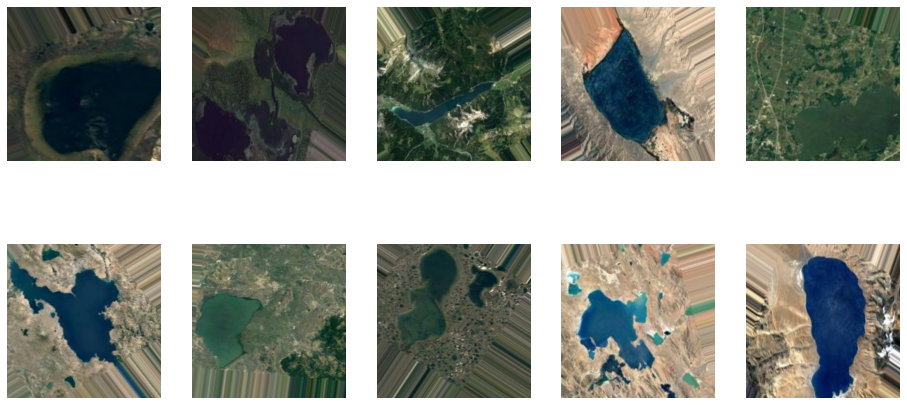

In [31]:
plot_batch(aug_train_img_batch, 10, 5, figsize=(16,8))

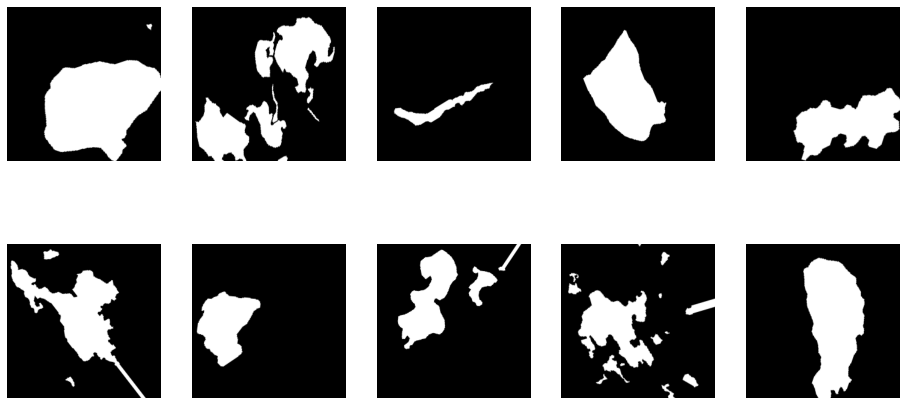

In [32]:
plot_batch(aug_train_msk_batch, 10, 5, figsize=(16,8))

Now I can easily and consitently apply augmentations to the data. Since I'm still using a single datagen object this means that both the training and validation data will have augmentations applied.

In [33]:
# Generate some validation data
aug_val_img = datagen.flow_from_dataframe(train_img_df,nwpu_data_dir,subset='validation',
                                            class_mode=None,shuffle=False, seed=42)
aug_val_msk = datagen.flow_from_dataframe(train_msk_df,nwpu_mask_dir,subset='validation',
                                            class_mode=None, shuffle=False, seed=42)

Found 90 validated image filenames.
Found 90 validated image filenames.


In [34]:
# Get the first batch
aug_val_img_batch = aug_val_img.next()
aug_val_msk_batch = aug_val_msk.next()

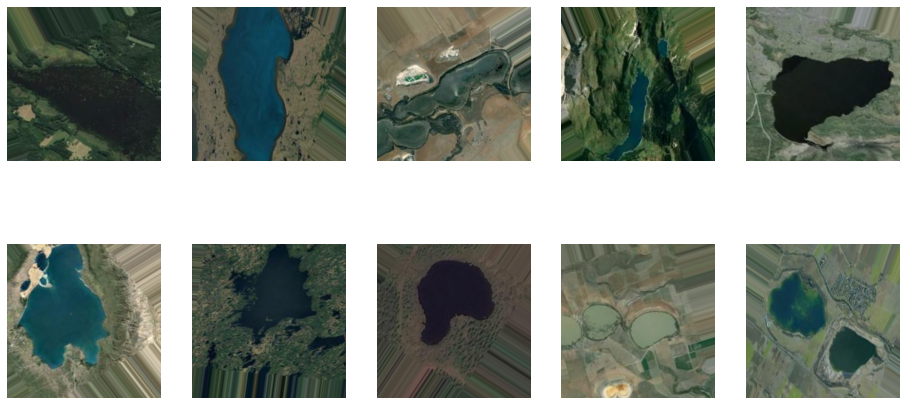

In [35]:
plot_batch(aug_val_img_batch, 10, 5, figsize=(16,8))

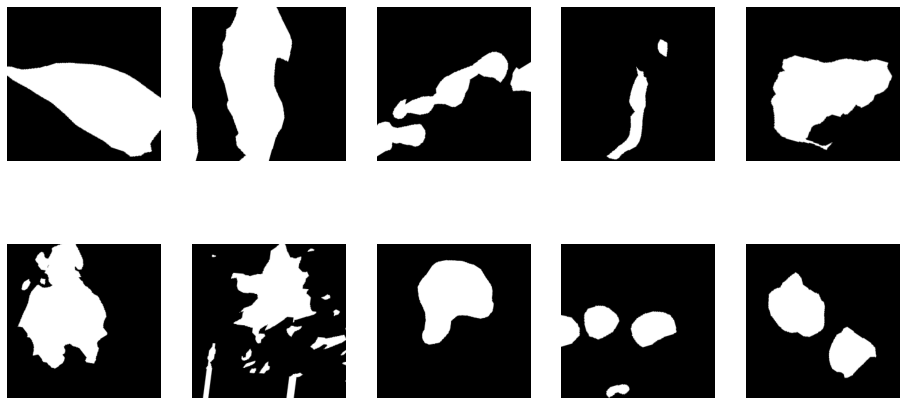

In [36]:
plot_batch(aug_val_msk_batch, 10, 5, figsize=(16,8))

<div class="alert alert-block alert-info"><b>Note:</b><br>It looks like the same augmentations that are applied to the training images are also applied to the validation images.
</div>

When using this kind of image augmentation on-the-fly i.e. augmented images are generated as part of the training process, the validation data should not be augmented. If it is then the validation data will not be consisent between the batches and epochs so it is difficult to get a good measure of the model's performance. Therefore a separate data generator should be used.

The validation data could instead be augmented before training and written to disk. Then it can be used consistently for evaluation. I wont look into this here but it could be an interesting experiment.

In [37]:
# Create training datagen
datagen_train = ImageDataGenerator(validation_split=0.3, # Split the data but i will only use training subset
                                   rotation_range=90,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   width_shift_range=0.15,
                                   height_shift_range=0.15,
                                   zoom_range=0.25,
                                   rescale=1/255.
                                  )

# Create validation datagen
datagen_val = ImageDataGenerator(validation_split=0.3, # Split the data but i will only use valiation subset
                                 rescale=1/255.
                                )

In [38]:
# Create the new training flows
aug_train_img2 = datagen_train.flow_from_dataframe(train_img_df,nwpu_data_dir,subset='training',
                                            class_mode=None,shuffle=False, seed=42)
aug_train_msk2 = datagen_train.flow_from_dataframe(train_msk_df,nwpu_mask_dir,subset='training',
                                            class_mode=None, shuffle=False, seed=42)

Found 210 validated image filenames.
Found 210 validated image filenames.


In [39]:
# Create the new training batches
aug_train_img_batch2 = aug_train_img2.next()
aug_train_msk_batch2 = aug_train_msk2.next()

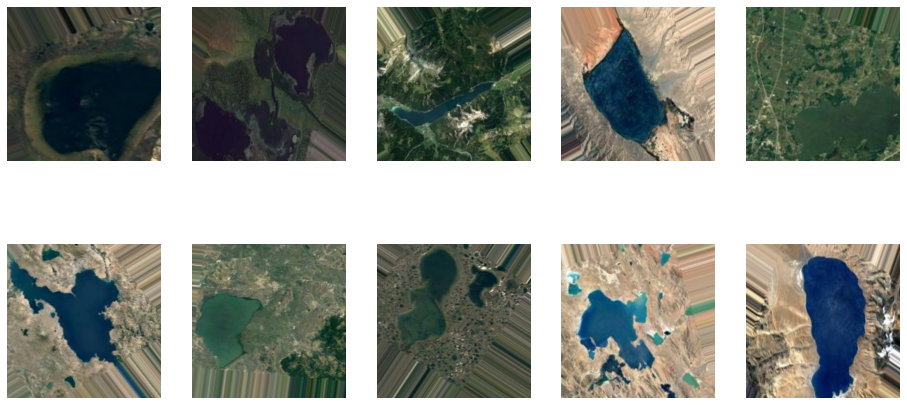

In [40]:
plot_batch(aug_train_img_batch, 10, 5, figsize=(16,8))

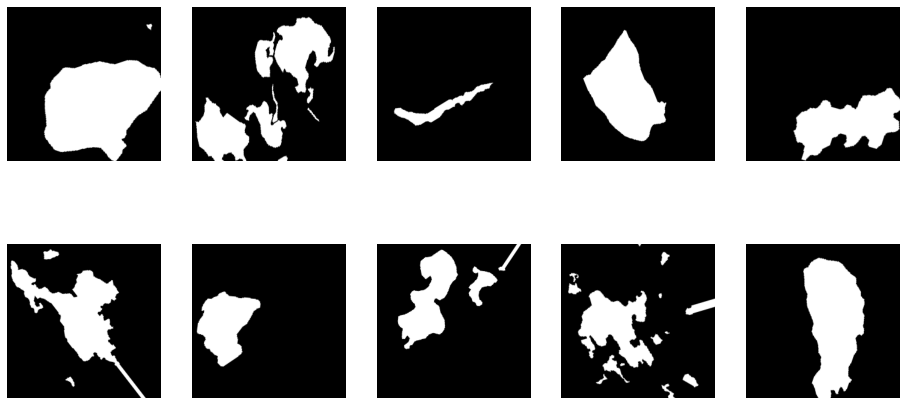

In [41]:
plot_batch(aug_train_msk_batch, 10, 5, figsize=(16,8))

In [42]:
aug_train_img.filenames == aug_train_img2.filenames

True

In [70]:
aug_train_msk.filenames == aug_train_msk2.filenames

True

The training data is the same as earlier since nothing has changed in that respect.

The validation data however should have not augmentations.

In [72]:
# Create the new validation flows - no seed required since no shuffling or
# augmentations applied
val_img = datagen_val.flow_from_dataframe(train_img_df,nwpu_data_dir,subset='validation',
                                          class_mode=None,shuffle=False)

val_msk = datagen_val.flow_from_dataframe(train_msk_df,nwpu_mask_dir,subset='validation',
                                          class_mode=None, shuffle=False)

Found 90 validated image filenames.
Found 90 validated image filenames.


In [73]:
# Create the new validation batches
val_img_batch = val_img.next()
val_msk_batch = val_msk.next()

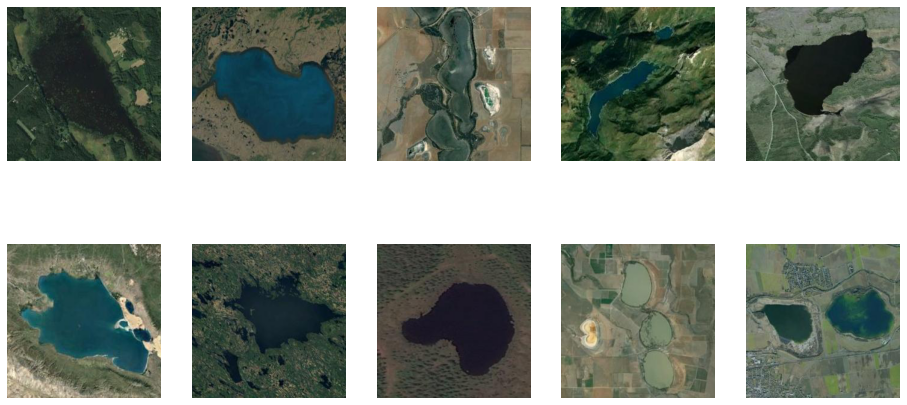

In [74]:
plot_batch(val_img_batch, 10, 5, figsize=(16,8))

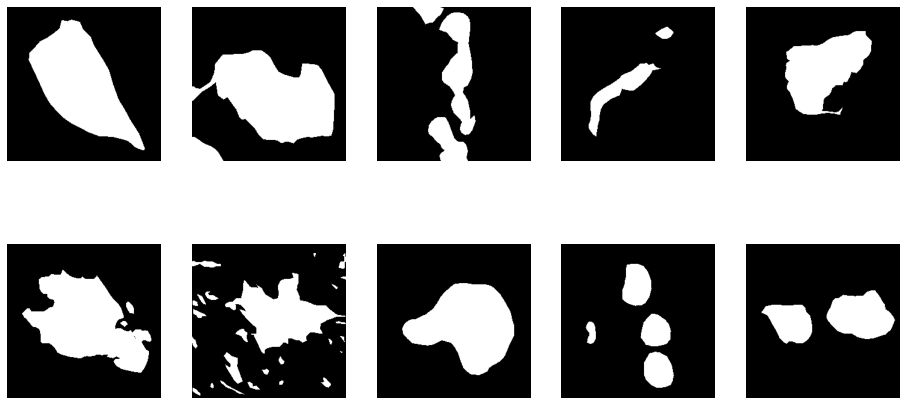

In [75]:
plot_batch(val_msk_batch, 10, 5, figsize=(16,8))

In [68]:
aug_val_img.filenames == val_img.filenames

True

In [69]:
aug_val_msk.filenames == val_msk.filenames

True

The filenames in this validation set match those in the augmented set as expected. However, it can be seen that in this case no augmention has been applied - great!

Now I'll create a function to reproduce this.

In [94]:
# Function to handle data augmentation
def flow_image_mask(img_df, msk_df, img_dir, msk_dir, val_split=0.0,
                    batch_size=32, aug_dict=None, aug_seed=42,
                    rescale=1/255
                   ):
    """Create image & mask generators
    
    Parameters
    ----------
    img_df: pd.DataFrame
    msk_df: pd.DataFrame
    img_dir: str
    msk_dir: str
    val_split: float, optional
    batch_size: int, optional
    **kwargs: dict
        Other keyword arguments that will be passed to the
        ImageDataGenerator
        
    Returns
    -------
    generator:
        If val_split is 0, only the training data generator
        is returned.
    tuple of generators and lists:
        If val_split > 0, training and validation generators
        are returned along with the filenames used for each
        split.
    """
    
    dg_init_args = {'validation_split': val_split}
    augment = aug_dict is not None and len(aug_dict) > 0
    if augment:
        dg_init_args.update(aug_dict)
    
    # Instantiate the data generator specifying a validation split.
    datagen = ImageDataGenerator(**dg_init_args, rescale=rescale)
    
    # Create the training data generators first
    train_img_gen = datagen.flow_from_dataframe(img_df,
                                                img_dir,
                                                y_col=None,
                                                class_mode=None,
                                                shuffle=None,
                                                subset='training',
                                                batch_size=batch_size,
                                                seed = aug_seed if augment else None
                                               )
    
    train_msk_gen = datagen.flow_from_dataframe(msk_df,
                                                msk_dir,
                                                y_col=None,
                                                class_mode=None,
                                                shuffle=None,
                                                subset='training',
                                                color_mode='grayscale',
                                                batch_size=batch_size,
                                                seed = aug_seed if augment else None
                                               )
    # Combine
    train_gen = (pair for pair in zip(train_img_gen, train_msk_gen))
    
    # If val_split is greater than 0, i.e. the data is actually split
    # create the validation data generators
    val_gen = None
    if val_split > 0:
        if augment:
            val_datagen = ImageDataGenerator(validation_split=val_split,
                                             rescale=rescale)
        else:
            val_datagen = datagen
            
        val_img_gen = val_datagen.flow_from_dataframe(img_df,
                                                  img_dir,
                                                  y_col=None,
                                                  class_mode=None,
                                                  shuffle=None,
                                                  subset='validation',
                                                  batch_size=batch_size
                                                 )

        val_msk_gen = datagen.flow_from_dataframe(msk_df,
                                                  msk_dir,
                                                  y_col=None,
                                                  class_mode=None,
                                                  shuffle=None,
                                                  subset='validation',
                                                  color_mode='grayscale',
                                                  batch_size=batch_size
                                                 )
        
        val_gen = (pair for pair in zip(val_img_gen, val_msk_gen))
        
    if val_gen is None:
        # If no split has been done just return train_gen
        return train_gen
    else:
        # Otherwise return train_gen and val_gen and also
        # the file paths that fall into each split to ensure
        # reproducibility
        
        train_fps = train_img_gen.filepaths
        val_fps = val_img_gen.filepaths
        
        return (train_gen, val_gen, train_fps, val_fps)

In [111]:
# Split the training data into train and validation generators
aug_dict = {'rotation_range':90,
            'horizontal_flip':True,
            'vertical_flip':True,
            'width_shift_range':0.15,
            'height_shift_range':0.15,
            'zoom_range':0.25
           }

train_gen, val_gen, train_fps, val_fps = flow_image_mask(train_img_df, train_msk_df,
                                                         nwpu_data_dir, nwpu_mask_dir,
                                                         val_split=0.3, rescale=1/255.,
                                                         aug_dict=aug_dict
                                                        )

Found 210 validated image filenames.
Found 210 validated image filenames.
Found 90 validated image filenames.
Found 90 validated image filenames.


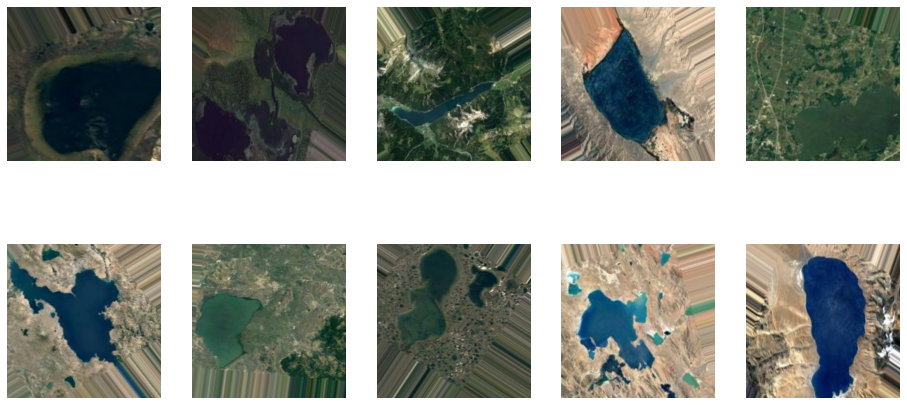

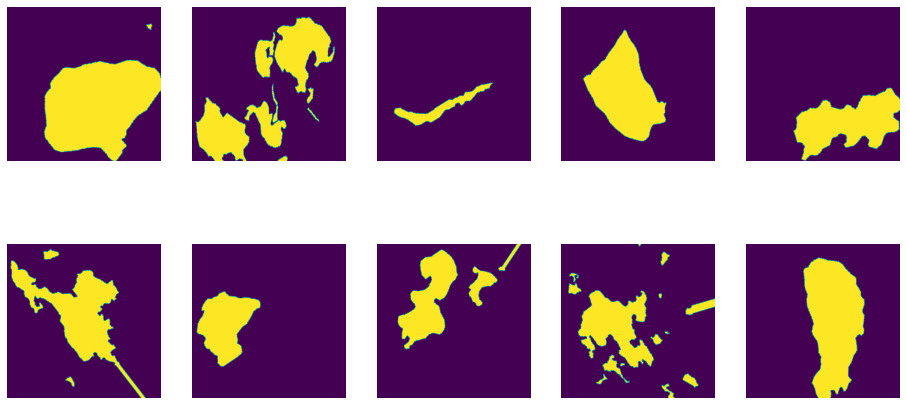

In [112]:
ti, tm = next(train_gen)
plot_batch(ti, 10, 5, figsize=(16,8))
plot_batch(tm, 10, 5, figsize=(16,8))

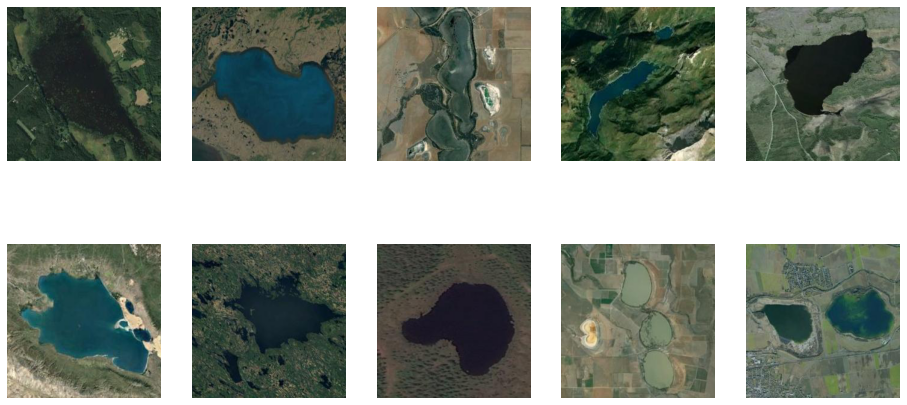

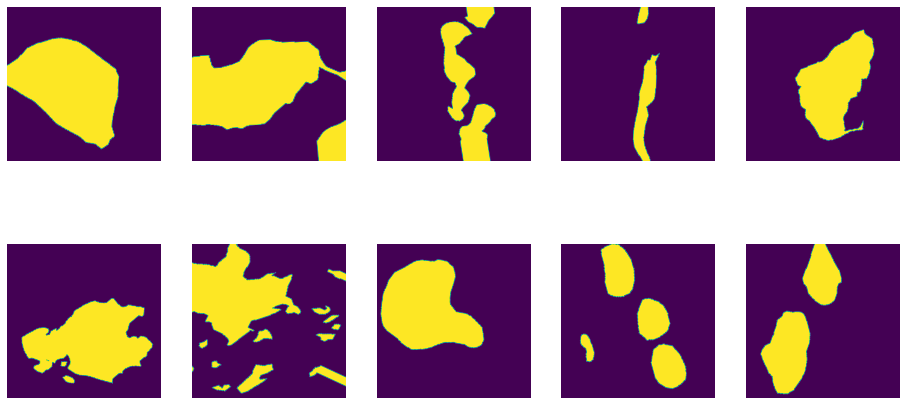

In [113]:
vi, vm = next(val_gen)
plot_batch(vi, 10, 5, figsize=(16,8))
plot_batch(vm, 10, 5, figsize=(16,8))